# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

Link to Github repo: https://github.com/martinkirov/dsnd-capstone <br>
Link to blogpost on Medium: https://medium.com/@martin701993/sparkify-capstone-project-86c9618d9c95

In [117]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
import datetime
from pyspark.sql.types import IntegerType
from pyspark.sql import Window

import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier

from pyspark.sql import Window
import pyspark.sql.functions as f

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("EDA using pyspark") \
    .getOrCreate()

In [3]:
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

In [5]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
user_log.take(3)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [7]:
# Total number of rows
user_log.count()

286500

In [8]:
# Find the blanks in non-string columns
["{}: {}".format(col,user_log.filter(user_log[col].isNull()).count()) for col in user_log.columns]

['artist: 58392',
 'auth: 0',
 'firstName: 8346',
 'gender: 8346',
 'itemInSession: 0',
 'lastName: 8346',
 'length: 58392',
 'level: 0',
 'location: 8346',
 'method: 0',
 'page: 0',
 'registration: 8346',
 'sessionId: 0',
 'song: 58392',
 'status: 0',
 'ts: 0',
 'userAgent: 8346',
 'userId: 0']

In [9]:
# Get the blanks in string columns
["{}: {}".format(col,user_log.filter(user_log[col] == "").count()) for col in user_log.columns]

['artist: 0',
 'auth: 0',
 'firstName: 0',
 'gender: 0',
 'itemInSession: 0',
 'lastName: 0',
 'length: 0',
 'level: 0',
 'location: 0',
 'method: 0',
 'page: 0',
 'registration: 0',
 'sessionId: 0',
 'song: 0',
 'status: 0',
 'ts: 0',
 'userAgent: 0',
 'userId: 8346']

### MK Comment:
From the given columns, we need to check out:
+ userId (8k)
+ userAgent (8k)
+ firstName (8k)
+ gender (8k)
+ lastName (8k)
+ location (8k)
+ registration (8k)
+ artist (58k)
+ length (58k)
+ song (58k)

Lets check if the columns with 8k missing records match up:

In [10]:
user_log \
.select(['userId', 'userAgent', 'firstName', 'gender', 'lastName', 'location', 'registration', 'artist']) \
.filter(user_log['userAgent'].isNull() &  user_log['gender'].isNotNull() ) \
.show()

+------+---------+---------+------+--------+--------+------------+------+
|userId|userAgent|firstName|gender|lastName|location|registration|artist|
+------+---------+---------+------+--------+--------+------------+------+
+------+---------+---------+------+--------+--------+------------+------+



### MK Comment:

The 8k features do match up; these are all logged out screens which we arent too interested in and we'll drop.

How about the features with 58k missing values? 

In [11]:
user_log \
.filter(user_log.artist.isNull()) \
.select('userId','method', 'page','status','sessionId','registration') \
.show()

+------+------+---------------+------+---------+-------------+
|userId|method|           page|status|sessionId| registration|
+------+------+---------------+------+---------+-------------+
|    30|   PUT|Add to Playlist|   200|       29|1538173362000|
|     9|   GET|    Roll Advert|   200|        8|1538331630000|
|     9|   PUT|      Thumbs Up|   307|        8|1538331630000|
|    54|   GET|      Downgrade|   200|       53|1532482662000|
|    54|   PUT|      Thumbs Up|   307|       53|1532482662000|
|     9|   PUT|    Thumbs Down|   307|        8|1538331630000|
|     9|   GET|           Home|   200|        8|1538331630000|
|     9|   PUT|         Logout|   307|        8|1538331630000|
|    74|   PUT|      Thumbs Up|   307|      217|1537365219000|
|      |   GET|           Home|   200|        8|         null|
|      |   GET|           Help|   200|        8|         null|
|      |   GET|           Home|   200|        8|         null|
|      |   PUT|          Login|   307|        8|       

In [12]:
user_log \
.filter(user_log.sessionId == 187) \
.sort('ts') \
.select('ts', 'userAgent','method', 'page','status','sessionId','registration') \
.show(1000)

+-------------+--------------------+------+---------------+------+---------+-------------+
|           ts|           userAgent|method|           page|status|sessionId| registration|
+-------------+--------------------+------+---------------+------+---------+-------------+
|1538359181000|"Mozilla/5.0 (Win...|   GET|           Home|   200|      187|1538304455000|
|1538359204000|"Mozilla/5.0 (Win...|   PUT|       NextSong|   200|      187|1538304455000|
|1538359398000|"Mozilla/5.0 (Win...|   PUT|       NextSong|   200|      187|1538304455000|
|1538359596000|"Mozilla/5.0 (Win...|   PUT|       NextSong|   200|      187|1538304455000|
|1538359749000|"Mozilla/5.0 (Win...|   PUT|       NextSong|   200|      187|1538304455000|
|1538359971000|"Mozilla/5.0 (Win...|   PUT|       NextSong|   200|      187|1538304455000|
|1538360229000|"Mozilla/5.0 (Win...|   PUT|       NextSong|   200|      187|1538304455000|
|1538360490000|"Mozilla/5.0 (Win...|   PUT|       NextSong|   200|      187|1538304455000|

`registration` and `ts` need to be reformatted. 

In [13]:
convert_ts = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
user_log = user_log.withColumn('event_time', convert_ts('ts'))
user_log = user_log.withColumn('registration_time', convert_ts('registration'))

In [14]:
log_data = user_log.filter(user_log['userId'] != "")

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [15]:
# define the churn and downgrade events we want to flag
churn_flag = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
downgrade_flag = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())

In [16]:
# create churn_event and downgrade_event columns
log_data = log_data.withColumn('churn_event', churn_flag("page"))
log_data = log_data.withColumn('downgrade_event', downgrade_flag("page"))

In [17]:
# label users that have ever churned
churned_users = set(log_data.filter(log_data['churn_event'] == 1).select('userId').dropDuplicates().toPandas().userId)
churned_user = udf(lambda x: 1 if x in churned_users else 0, IntegerType())
log_data = log_data.withColumn('churn_user', churned_user('userId'))

In [18]:
# label users that have ever downgraded
downgraded_users = set(log_data.filter(log_data['downgrade_event'] == 1).select('userId').dropDuplicates().toPandas().userId)
downgrade_user = udf(lambda x: 1 if x in downgraded_users else 0, IntegerType())
log_data = log_data.withColumn('downgrade_user', downgrade_user('userId'))

In [19]:
df = log_data.toPandas()

# 2. Exploratory Analysis

## 2.1 High level plan

We will treat the EDA part as a learning experience to learn about the dataset and get enough insight so as to construct a useful end-table that we will apply ML algorithms on.


### 2.2. Basic Info

In [119]:
df.shape

(278154, 24)

In [21]:
df.head().transpose()

,0,1,2,3,4
artist,Martha Tilston,Five Iron Frenzy,Adam Lambert,Enigma,Daft Punk
auth,Logged In,Logged In,Logged In,Logged In,Logged In
firstName,Colin,Micah,Colin,Micah,Colin
gender,M,M,M,M,M
itemInSession,50,79,51,80,52
lastName,Freeman,Long,Freeman,Long,Freeman
length,277.89,236.094,282.827,262.713,223.608
level,paid,free,paid,free,paid
location,"Bakersfield, CA","Boston-Cambridge-Newton, MA-NH","Bakersfield, CA","Boston-Cambridge-Newton, MA-NH","Bakersfield, CA"
method,PUT,PUT,PUT,PUT,PUT


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278154 entries, 0 to 278153
Data columns (total 24 columns):
artist               228108 non-null object
auth                 278154 non-null object
firstName            278154 non-null object
gender               278154 non-null object
itemInSession        278154 non-null int64
lastName             278154 non-null object
length               228108 non-null float64
level                278154 non-null object
location             278154 non-null object
method               278154 non-null object
page                 278154 non-null object
registration         278154 non-null int64
sessionId            278154 non-null int64
song                 228108 non-null object
status               278154 non-null int64
ts                   278154 non-null int64
userAgent            278154 non-null object
userId               278154 non-null object
event_time           278154 non-null object
registration_time    278154 non-null object
churn_event  

In [23]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
itemInSession,278154.0,1.148992e+02,1.298517e+02,0.000000e+00,2.700000e+01,7.000000e+01,1.570000e+02,1.321000e+03
length,228108.0,2.491172e+02,9.923518e+01,7.832200e-01,1.998885e+02,2.345008e+02,2.771587e+02,3.024666e+03
registration,278154.0,1.535359e+12,3.291322e+09,1.521381e+12,1.533522e+12,1.536664e+12,1.537672e+12,1.543247e+12
sessionId,278154.0,1.042562e+03,7.265010e+02,1.000000e+00,3.380000e+02,1.017000e+03,1.675000e+03,2.474000e+03
status,278154.0,2.091032e+02,3.015139e+01,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,4.040000e+02
ts,278154.0,1.540959e+12,1.506829e+09,1.538352e+12,1.539699e+12,1.540934e+12,1.542268e+12,1.543799e+12
churn_event,278154.0,1.869468e-04,1.367160e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
downgrade_event,278154.0,2.264932e-04,1.504801e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
churn_user,278154.0,1.612919e-01,3.678007e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
downgrade_user,278154.0,3.834279e-01,4.862220e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00


#### How many unique values do we have for each feature? (both categorical and continuous)

Note: we will gather all the variables that have less than 100 unique values into `cols_to_check_further` to explore further.

In [24]:
## Unique vals in each var
cols_to_check_further = []
for col in df.columns:
    no_unique_vals = len(df[col].unique())
    print("{}: {}".format(col, no_unique_vals))
    if no_unique_vals < 100:
        cols_to_check_further.append(col)

artist: 17656
auth: 2
firstName: 189
gender: 2
itemInSession: 1311
lastName: 173
length: 14866
level: 2
location: 114
method: 2
page: 19
registration: 225
sessionId: 2312
song: 58481
status: 3
ts: 269770
userAgent: 56
userId: 225
event_time: 269770
registration_time: 225
churn_event: 2
downgrade_event: 2
churn_user: 2
downgrade_user: 2


#### 2.2.1. Unique Value Counts

For ease of analysis, lets construct a dictionary, `uvc`, that will hold all the value counts for the variables in `cols_to_check_further`.

In [174]:
# uncomment for activity-based counting vs user-based counting
"""
uvc = {}
for col in cols_to_check_further:
    uvc[col] = pd.DataFrame(df[col].value_counts())
"""

'\nuvc = {}\nfor col in cols_to_check_further:\n    uvc[col] = pd.DataFrame(df[col].value_counts())\n'

In [141]:
uvc = {}
for col in cols_to_check_further:
    uvc[col] = pd.DataFrame(df[['userId', col]].drop_duplicates()[col].value_counts())

In [26]:
cols_to_check_further

['auth',
 'gender',
 'level',
 'method',
 'page',
 'status',
 'userAgent',
 'churn_event',
 'downgrade_event',
 'churn_user',
 'downgrade_user']

In [142]:
uvc['auth']

,auth
Logged In,225
Cancelled,52


In [143]:
uvc['gender']

,gender
M,121
F,104


In [144]:
uvc['method']

,method
PUT,225
GET,224


In [145]:
uvc['level']

,level
free,195
paid,165


In [146]:
uvc['userAgent'].head()

,userAgent
"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",24
Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,18
"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36""",16
"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4""",12
"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",12


In [173]:
# Get the number of users that have moved between paid and free (both directions)

free_paid_users = df[['userId', 'level']].drop_duplicates()

len(free_paid_users[free_paid_users.duplicated(subset="userId")].sort_values(by="userId"))

135

### 2.3. Single Var Exploration

The above dataframes give us the exact value counts within each variable but it not too convenient when it comes to getting a feel for the data. Let's chart out all of the `uvc` data and see - in percentage terms - how they are distributed.

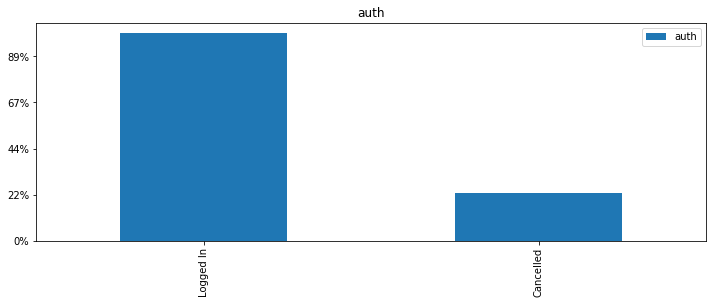

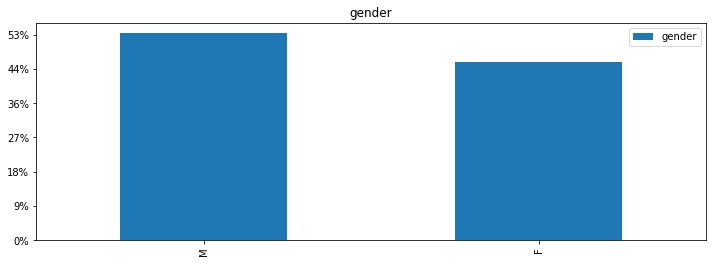

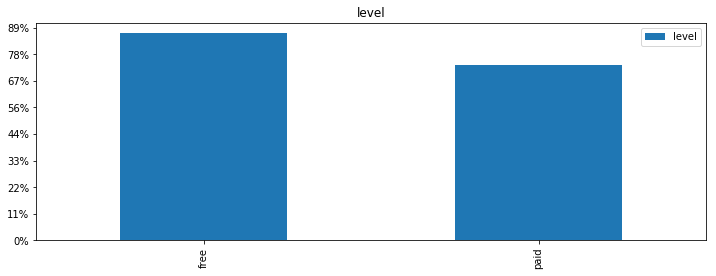

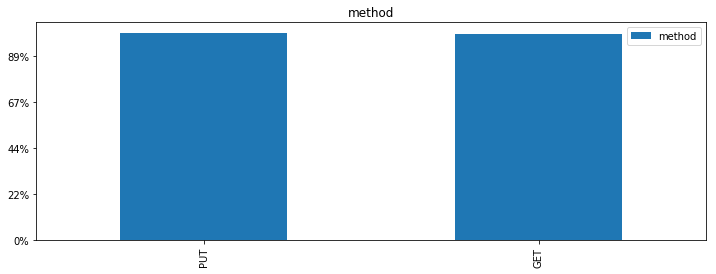

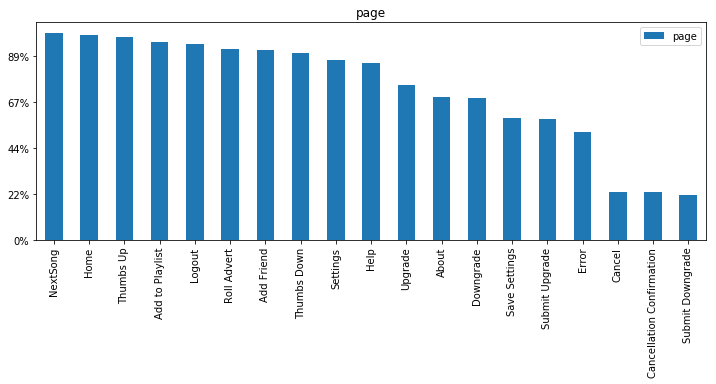

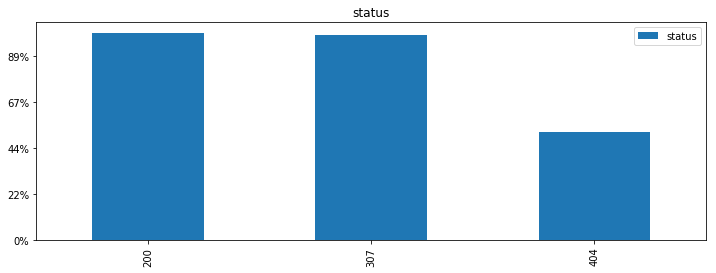

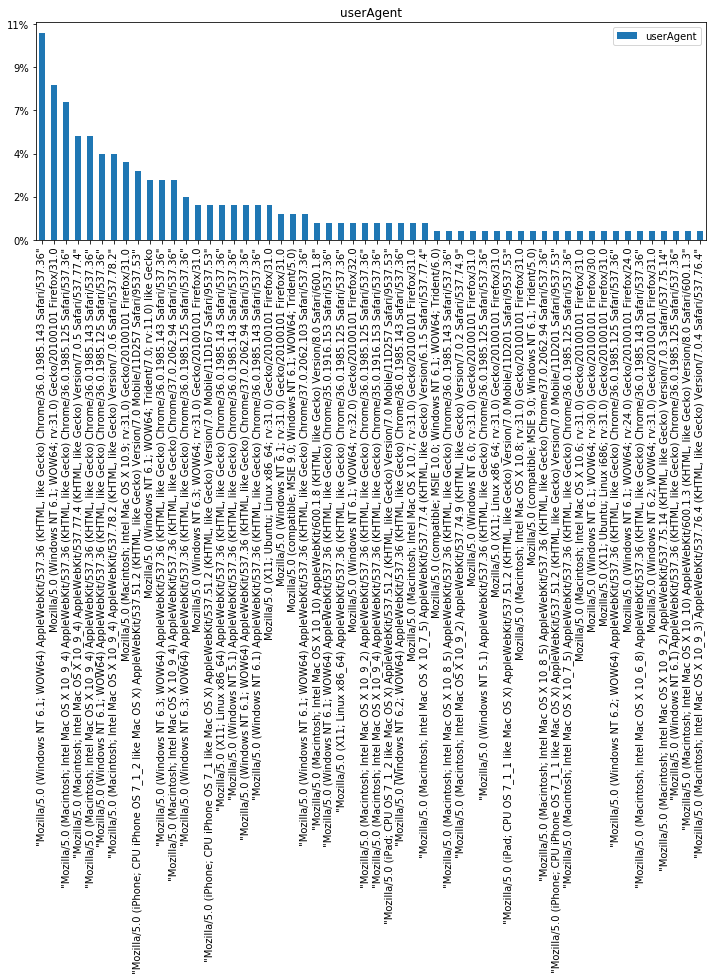

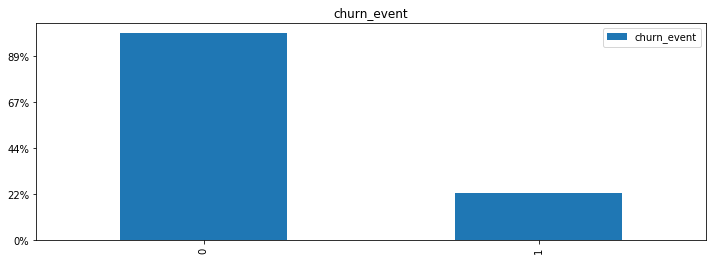

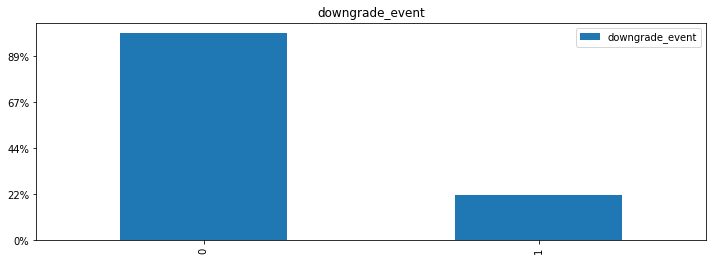

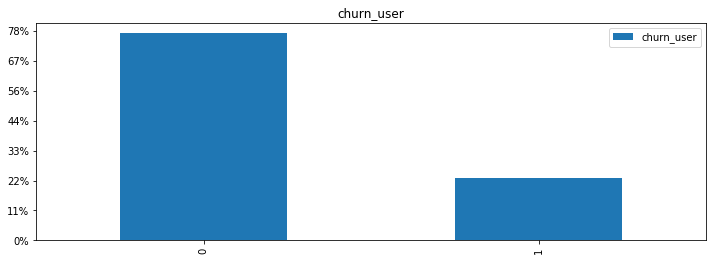

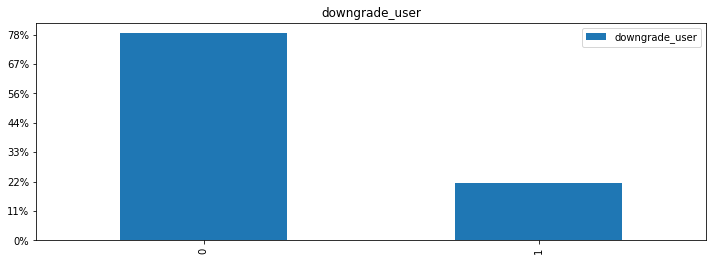

In [148]:
for col in uvc.keys():
    uvc[col].plot(kind='bar', legend=True, title=col, figsize = (12,4))

    #reformat the y-axis to percentages
    plt.gca().set_yticklabels(['{:.0f}%'.format(100*x/225) for x in plt.gca().get_yticks()])
    plt.show()

### 2.4. Non-Categorical variable (sanity) check

In [33]:
nc_vars = list(set(df.columns) - set(uvc.keys()) - set(['userId']))

In [34]:
user = '126'
df[df['userId'] == user][nc_vars]

,firstName,registration_time,location,lastName,itemInSession,registration,length,sessionId,ts,song,event_time,artist
635,Daelin,2018-09-29 13:23:28,"New York-Newark-Jersey City, NY-NJ-PA",Turner,0,1538227408000,NaN,125,1538387004000,None,2018-10-01 09:43:24,None
636,Daelin,2018-09-29 13:23:28,"New York-Newark-Jersey City, NY-NJ-PA",Turner,1,1538227408000,232.69832,125,1538387041000,That Should Be Me,2018-10-01 09:44:01,Justin Bieber
648,Daelin,2018-09-29 13:23:28,"New York-Newark-Jersey City, NY-NJ-PA",Turner,2,1538227408000,372.76689,125,1538387273000,I've Got Your Number,2018-10-01 09:47:53,Passion Pit
657,Daelin,2018-09-29 13:23:28,"New York-Newark-Jersey City, NY-NJ-PA",Turner,3,1538227408000,225.51465,125,1538387645000,Repair Machines,2018-10-01 09:54:05,Vitalic
659,Daelin,2018-09-29 13:23:28,"New York-Newark-Jersey City, NY-NJ-PA",Turner,4,1538227408000,NaN,125,1538387676000,None,2018-10-01 09:54:36,None
664,Daelin,2018-09-29 13:23:28,"New York-Newark-Jersey City, NY-NJ-PA",Turner,5,1538227408000,196.17914,125,1538387870000,Bubbly,2018-10-01 09:57:50,Colbie Caillat
669,Daelin,2018-09-29 13:23:28,"New York-Newark-Jersey City, NY-NJ-PA",Turner,6,1538227408000,399.51628,125,1538388066000,Come On,2018-10-01 10:01:06,The Verve
682,Daelin,2018-09-29 13:23:28,"New York-Newark-Jersey City, NY-NJ-PA",Turner,7,1538227408000,336.74404,125,1538388465000,Sinisten tÃÂ¤htien alla,2018-10-01 10:07:45,J. Karjalainen & Mustat Lasit
692,Daelin,2018-09-29 13:23:28,"New York-Newark-Jersey City, NY-NJ-PA",Turner,8,1538227408000,371.90485,125,1538388801000,Keep The Fire Burnin',2018-10-01 10:13:21,Future Breeze
706,Daelin,2018-09-29 13:23:28,"New York-Newark-Jersey City, NY-NJ-PA",Turner,9,1538227408000,3024.66567,125,1538389172000,Monolithe II,2018-10-01 10:19:32,Monolithe


### 2.5. Number of listening sessions on Sparkify

Let us consider the number of listening sessions that Sparkify users have. From the sample data we have, the `sessionId` feature gives the unique id of the session that the user is currently listening to. Every single user will have one or more sessions. 

We would like to see how the users are distributed based on the sessions they have.

In [35]:
xx = df.groupby(['userId'])

In [36]:
xx.get_group('125').sessionId

36599    174
36605    174
36613    174
36618    174
36626    174
36634    174
36641    174
36646    174
36647    174
36648    174
36649    174
Name: sessionId, dtype: int64

In [37]:
no_sessions = xx.sessionId.nunique().sort_values(ascending = False)

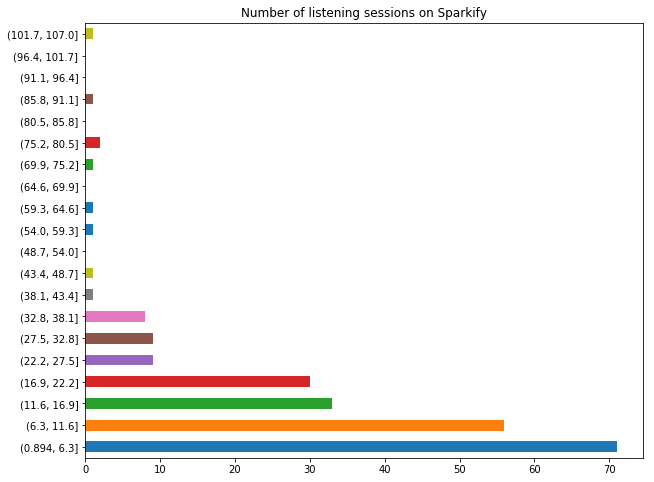

In [38]:
pd.cut(no_sessions, 20).value_counts(sort=False).plot(kind='barh', \
                                                      title = "Number of listening sessions on Sparkify", \
                                                      figsize = (10,8));

That's interesting - about 70 users or ~ 30% of the users in our dataset only use Sparkify a few times (between 0 and 6 times), and then the more sessions we consider, the less users have reach the number as a milestone.

### 2.6. What devices do users have

Let's consider what information we can obtain from the `userAgent` variable. 

There are about 55 different types of userAgents and it's not possible to figure out what browser and machine the user had - at least not without external help. Luckily for us, there are websites (I used this one: https://developers.whatismybrowser.com/useragents/parse/) where you can input a `userAgent` signature and you'll get back the browser and machine used. 

It took me about 15 mins to manually enter each of the 55 and parse the data out -- the `test` variable below contains what I parsed in the website and what we will be joining to our data later on.

In [39]:
userAgents = pd.DataFrame(df.userAgent.value_counts())

In [40]:
# this is manually parsed browser and machine used for each UserAgent
test = """userAgent	Browser	Machine	
\"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36\"	Chrome 36	Windows 7	
\"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4\"	Safari 7	Mavericks	
\"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36\"	Chrome 36	Mavericks	
\"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36\"	Chrome 36	Mavericks	
Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0	Firefox 31	Windows 7	
\"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36\"	Chrome 36	Windows 7	
\"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36\"	Chrome 37	Windows 7	
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:31.0) Gecko/20100101 Firefox/31.0	Firefox 31	Mavericks	
\"Mozilla/5.0 (iPad; CPU OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53\"	Safari 7	iPad	
Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0)	IE 9	Windows 7	
\"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.78.2 (KHTML, like Gecko) Version/7.0.6 Safari/537.78.2\"	Safari 7	Mavericks	
\"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36\"	Chrome 36	Windows 7	
\"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36\"	Chrome 37	Mavericks	
\"Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36\"	Chrome 36	Windows 8_1	
\"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53\"	Safari 7	iPhone	
Mozilla/5.0 (Windows NT 6.3; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0	Firefox 31	Windows 8.1	
\"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10) AppleWebKit/600.1.8 (KHTML, like Gecko) Version/8.0 Safari/600.1.8\"	Safari 8	Yosemite	
\"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36\"	Chrome 36	Windows XP	
\"Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36\"	Chrome 36	Windows 8.1	
Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko	IE 11	Windows 7	
\"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36\"	Chrome 37	Windows 7	
Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) Gecko/20100101 Firefox/32.0	Firefox 32	Windows 7	
Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) Gecko/20100101 Firefox/30.0	Firefox 30	Windows 7	
\"Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36\"	Chrome 36	Windows 8	
\"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36\"	Chrofme 36	Linux	
\"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36\"	Chrome 36	Mavericks	
\"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D167 Safari/9537.53\"	Safari 7	iPhone	
Mozilla/5.0 (X11; Linux x86_64; rv:31.0) Gecko/20100101 Firefox/31.0	Firefox 31	Linux	
\"Mozilla/5.0 (iPad; CPU OS 7_1_1 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D201 Safari/9537.53\"	Safari 7	iPad	
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; rv:31.0) Gecko/20100101 Firefox/31.0	Firefox 31	Lion	
Mozilla/5.0 (Windows NT 6.0; rv:31.0) Gecko/20100101 Firefox/31.0	Firefox 31	WIndows Vista	
\"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36\"	Chrome 35	Windows 7	
\"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36\"	Chrome 36	Windows XP	
Mozilla/5.0 (Windows NT 6.2; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0	Firefox 31	Windows 8	
\"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36\"	Chrome 36	Windows 7	
\"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.76.4 (KHTML, like Gecko) Version/7.0.4 Safari/537.76.4\"	Safari 7	Mavericks	
\"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_1 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D201 Safari/9537.53\"	Safari 7	iPhone	
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.8; rv:31.0) Gecko/20100101 Firefox/31.0	Firefox 31	Mountain Lion	
Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:31.0) Gecko/20100101 Firefox/31.0	Firefox 31	Linux	
\"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36\"	Chrome 36	Linux	
\"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10) AppleWebKit/600.1.3 (KHTML, like Gecko) Version/8.0 Safari/600.1.3\"	Safari 8	Yosemite	
\"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36\"	Chrome 35	Mavericks	
Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0)	IE 9	Windows 7	
Mozilla/5.0 (Windows NT 6.1; WOW64; rv:24.0) Gecko/20100101 Firefox/24.0	Firefox 24	Windows 7	
\"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2) AppleWebKit/537.74.9 (KHTML, like Gecko) Version/7.0.2 Safari/537.74.9\"	Safari 7	Mavericks	
Mozilla/5.0 (Windows NT 6.1; rv:31.0) Gecko/20100101 Firefox/31.0	Firefox 31	Windows 7	
Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.1; WOW64; Trident/6.0)	IE 10	Windows 7	
\"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_5) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/6.1.5 Safari/537.77.4\"	Safari 6_1	Lion	
\"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2) AppleWebKit/537.75.14 (KHTML, like Gecko) Version/7.0.3 Safari/537.75.14\"	Safari 7	Mavericks	
\"Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36\"	Chrome 36	Windows 8	
\"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36\"	Chrome 36	Lion	
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; rv:31.0) Gecko/20100101 Firefox/31.0	Firefox 31	Snow Leopard	
\"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36\"	Chrome 36	Mountain Lion	
\"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36\"	Chrome 36	Mountain Lion	
\"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36\"	Chrome 36	Snow Leopard	
Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0	Firefox 31	Linux	"""

In [41]:
# create a 1-column dataframe with the manually-parsed data
x = pd.DataFrame(test.split('\t'))
# split the dataframe into three 1-col dataframes

# by userAgent
x0 = x[x.index % 3 == 0].reset_index()
# by browser
x1 = x[x.index % 3 == 1].reset_index()
# by machine used
x2 = x[x.index % 3 == 2].reset_index()

In [42]:
# data manipulation to line everything up
x = x1.join(x2, lsuffix='a', rsuffix='b')
x = x.drop(columns = ['indexa', 'indexb'])
x = x.rename(columns={'0a': 'browser', '0b': 'machine'})
x = x.iloc[1:]
x = x.reset_index().drop(columns = ['index'])
userAgents = userAgents.reset_index().join(x)

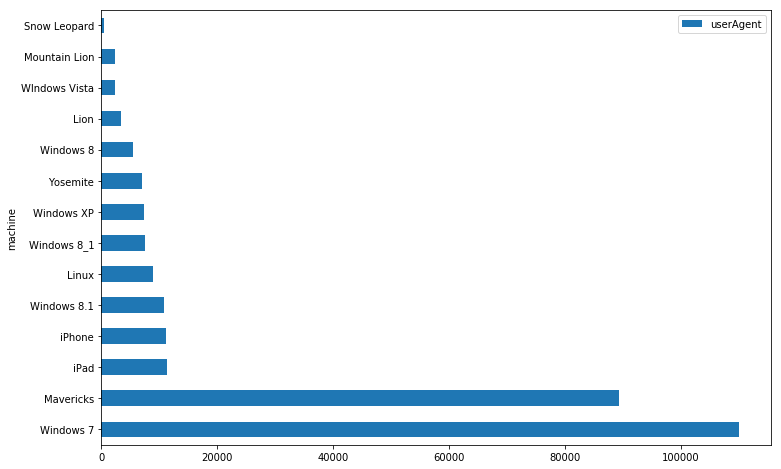

In [43]:
x = userAgents.groupby(['machine'])

x\
.agg('sum')\
.sort_values(['userAgent'], ascending = False)\
.plot(kind='barh', figsize=(12,8));

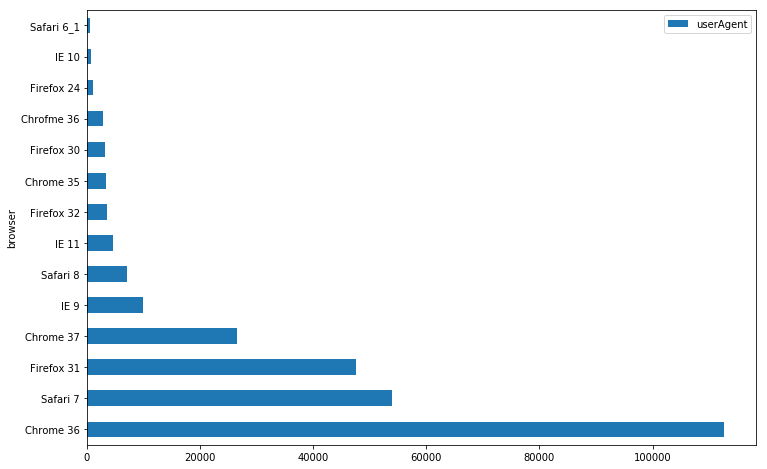

In [44]:
x = userAgents.groupby(['browser'])

x\
.agg('sum')\
.sort_values(['userAgent'], ascending = False)\
.plot(kind='barh', figsize=(12,8));

So, from the above two charts, we can see that most of our users use desktops as machines and a large proportion of them are Windows-based (either Windows XP, 7, 8 or 8.1). 

In terms of browsers used, Chrome (ver 36) is the most popular option with our users.

### 2.7. Run Diagram

try to recreate this: https://stackoverflow.com/questions/43367690/how-to-get-gantt-plot-using-matplotlib

In [45]:
## event_time and page

def get_user_run_diagram(user):
    cols = ['event_time', 'page', 'sessionId', 'itemInSession']
    user_run_diagram = df[df['userId'] == user][cols].copy()
    return user_run_diagram

def get_all_user_run_diagram():
    cols = ['event_time', 'page', 'sessionId', 'itemInSession']
    user_run_diagram = df[cols].copy()
    return user_run_diagram

In [46]:
def is_churn_user(user):
    if df[df.userId == user].churn_user.iloc[0] == 0:
        return "active"
    else:
        return "churn"


### 2.7.1. Run Diagram for all users

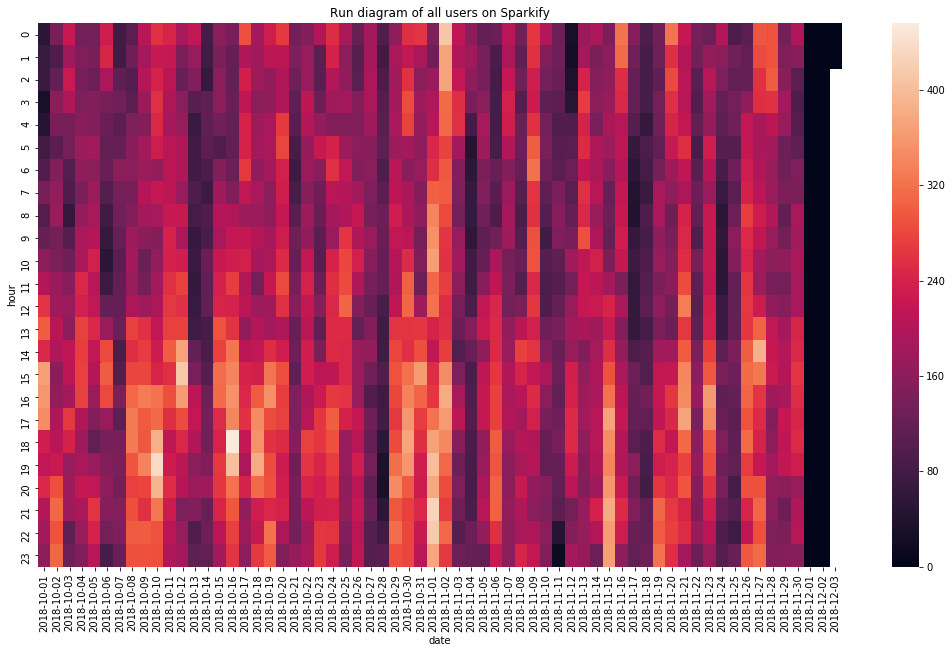

In [47]:
urd = get_all_user_run_diagram()
urd.index = pd.to_datetime(urd.event_time)

# count the hourly activity levels for the user
diag = urd.groupby(pd.Grouper(freq='H')).count()
# drop the redundant columns
diag = diag.drop(columns=['page', 'sessionId', 'itemInSession'])

diag['hour'] = diag.index.hour
diag['date'] = diag.index.date

fig, ax = plt.subplots(figsize=(18,10))
sns.heatmap(diag.pivot(index='hour', columns='date', values='event_time'))
ax.set_title("Run diagram of all users on Sparkify");

From the above diagram, we can see that - overall - daytime hours are busier than nighttime ones, and Fridays & Saturdays (e.g. 5th and 6th Oct 2018) tend to be quieter, presumaby since our users will probably be going out and not near their desktops/laptops.

We can also see that we seem to have a general decrease near the end of the month, followed by a surge - presumably at the start of a trial session, etc. - not possible to determine the reason with the current dataset.

### 2.7.2. Run diagram for a low-activity user

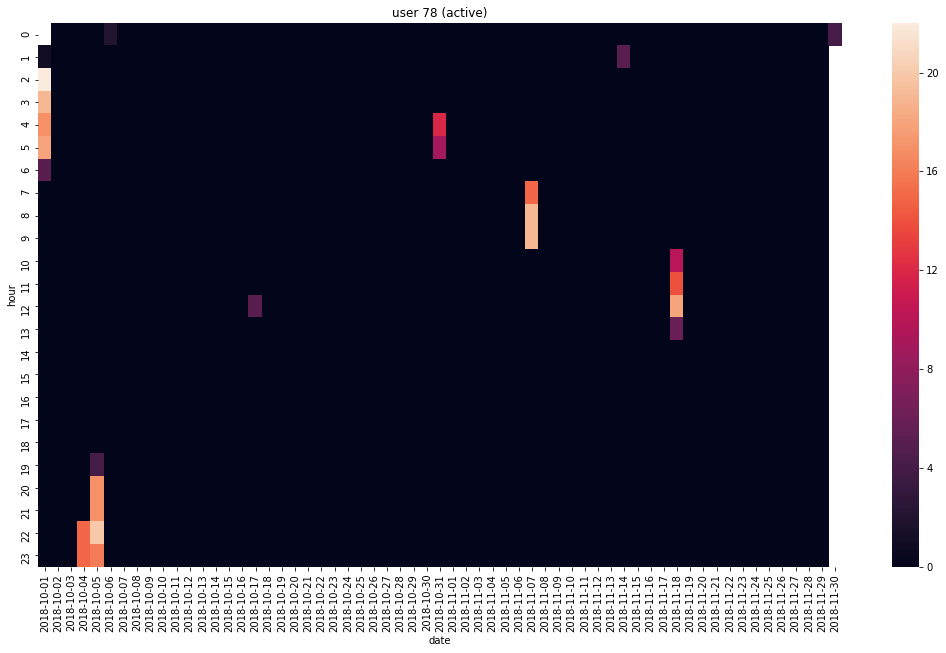

In [48]:
# user 78 or 79 (was 11)
user = '78'

urd = get_user_run_diagram(user)
has_user_churned = is_churn_user(user)
#urd = get_all_user_run_diagram()
urd.index = pd.to_datetime(urd.event_time)

# count the hourly activity levels for the user
diag = urd.groupby(pd.Grouper(freq='H')).count()
# drop the redundant columns
diag = diag.drop(columns=['page', 'sessionId', 'itemInSession'])

diag['hour'] = diag.index.hour
diag['date'] = diag.index.date

fig, ax = plt.subplots(figsize=(18,10))
sns.heatmap(diag.pivot(index='hour', columns='date', values='event_time'))
ax.set_title("user {} ({})".format(user, has_user_churned));

From the above diagram we can see that a typical low-activity user just has a few short sessions of using Sparkify, without any particular pattern to the usage.

### 2.7.3. Run Diagram for a medium-activity user

In [49]:
# user 200014 or 155

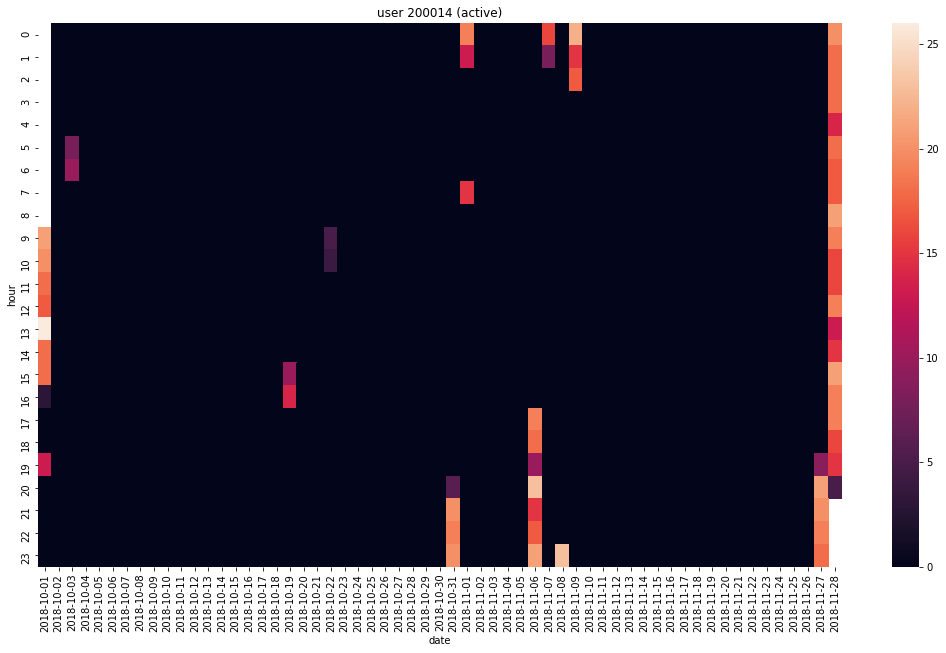

In [50]:
user = '200014'

urd = get_user_run_diagram(user)
has_user_churned = is_churn_user(user)
#urd = get_all_user_run_diagram()
urd.index = pd.to_datetime(urd.event_time)

# count the hourly activity levels for the user
diag = urd.groupby(pd.Grouper(freq='H')).count()
# drop the redundant columns
diag = diag.drop(columns=['page', 'sessionId', 'itemInSession'])

diag['hour'] = diag.index.hour
diag['date'] = diag.index.date

fig, ax = plt.subplots(figsize=(18,10))
sns.heatmap(diag.pivot(index='hour', columns='date', values='event_time'))
ax.set_title("user {} ({})".format(user, has_user_churned));

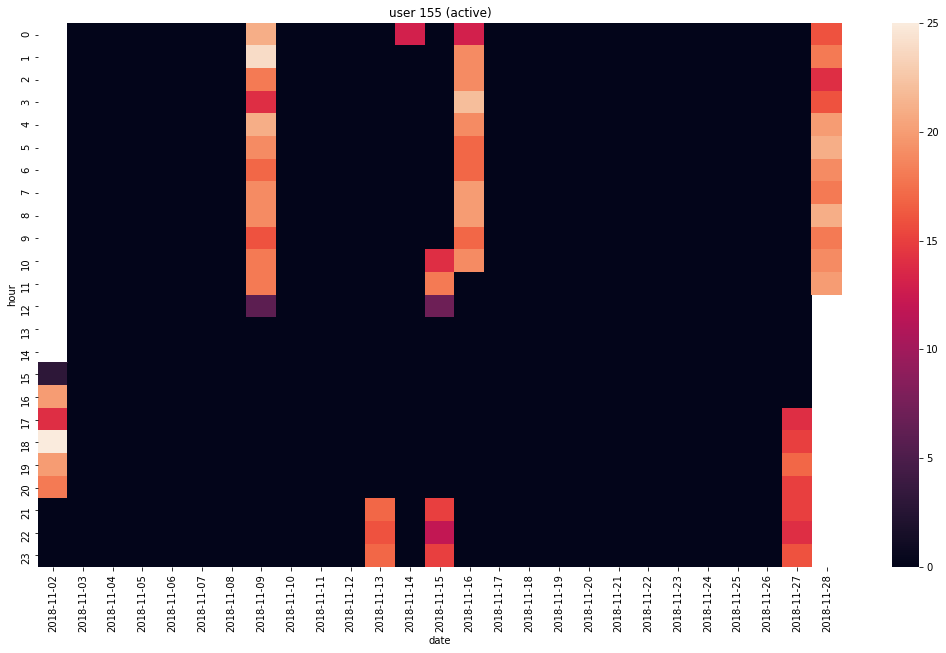

In [51]:
user = '155'

urd = get_user_run_diagram(user)
has_user_churned = is_churn_user(user)
#urd = get_all_user_run_diagram()
urd.index = pd.to_datetime(urd.event_time)

# count the hourly activity levels for the user
diag = urd.groupby(pd.Grouper(freq='H')).count()
# drop the redundant columns
diag = diag.drop(columns=['page', 'sessionId', 'itemInSession'])

diag['hour'] = diag.index.hour
diag['date'] = diag.index.date

fig, ax = plt.subplots(figsize=(18,10))
sns.heatmap(diag.pivot(index='hour', columns='date', values='event_time'))
ax.set_title("user {} ({})".format(user, has_user_churned));

For the above two diagrams we can see that a medium-activity user tends to have a few long sessions lasting a few hours, and they seem to appear around outside of typical 9-5 working hours. 

### 2.7.4. Run Diagram for a high-activity user

In [52]:
# user 39 or 92

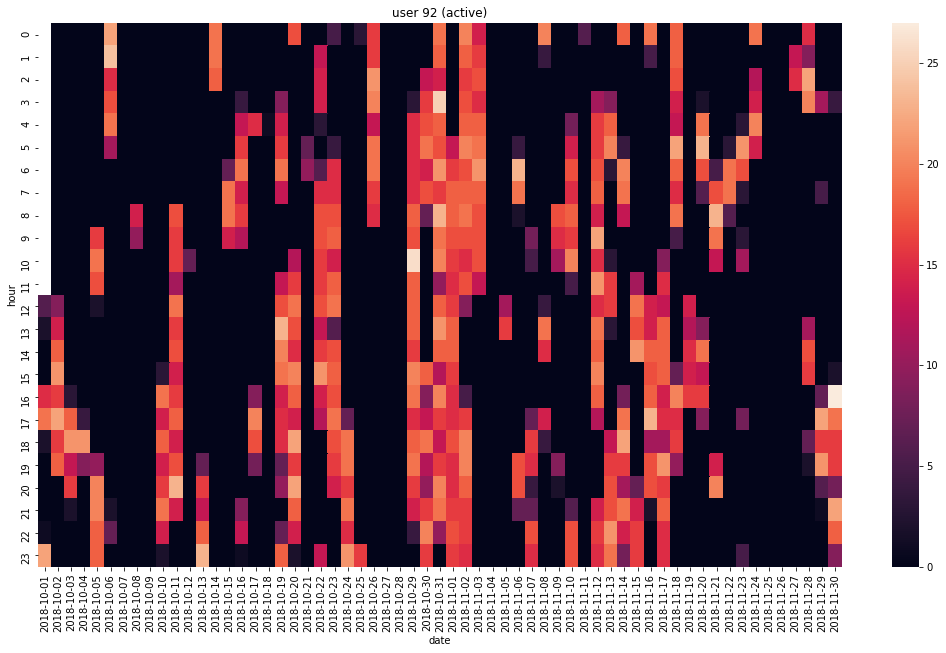

In [53]:
# Run the below line to get a list of users along with their activity levels - should
# you want to try the run diagram on any other users
#df.groupby('userId').status.count().sort_values(ascending = False)[150:250]

user = '92'

urd = get_user_run_diagram(user)
has_user_churned = is_churn_user(user)
#urd = get_all_user_run_diagram()
urd.index = pd.to_datetime(urd.event_time)

# count the hourly activity levels for the user
diag = urd.groupby(pd.Grouper(freq='H')).count()
# drop the redundant columns
diag = diag.drop(columns=['page', 'sessionId', 'itemInSession'])

diag['hour'] = diag.index.hour
diag['date'] = diag.index.date

fig, ax = plt.subplots(figsize=(18,10))
sns.heatmap(diag.pivot(index='hour', columns='date', values='event_time'))
ax.set_title("user {} ({})".format(user, has_user_churned));

User 92 is quite keen on the Sparkify service and listens to music all the time! We have a lot of daytime activity and (hypothetically) a lot of nighttime usage just for background music whilst sleeping. 

We can infer from the above that length of sessions is something that matters when it comes to whether a user wants to keep using the service or not and would be useful to include this in one form or another in our modelling table. The machine/ browser that the user uses is going to be important as well - so we'll add them as features in addition.  

# 3. Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Creating a summary table for the model - high level plan

Features:
- userId
- Device used (Mac, PC, Ipad, etc.)
- browser used
- number of sessions
- gender
- have they ever downgraded
- have they added a friend
- have they thumbs up or thumbs down a song
- churn

I considered a few extra features that I ultimately decided against - the code for them is below, for future reference. 

In [54]:
log_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- event_time: string (nullable = true)
 |-- registration_time: string (nullable = true)
 |-- churn_event: integer (nullable = true)
 |-- downgrade_event: integer (nullable = true)
 |-- churn_user: integer (nullable = true)
 |-- downgrade_user: integer (nullable = true)



In [55]:
log_data.select('userId').distinct().rdd

MapPartitionsRDD[277] at javaToPython at NativeMethodAccessorImpl.java:0

In [56]:
ml_table = spark.createDataFrame(log_data.select('userId').distinct().rdd)

In [57]:
ml_table.collect()

[Row(userId='100010'),
 Row(userId='200002'),
 Row(userId='125'),
 Row(userId='51'),
 Row(userId='124'),
 Row(userId='7'),
 Row(userId='54'),
 Row(userId='15'),
 Row(userId='155'),
 Row(userId='132'),
 Row(userId='154'),
 Row(userId='100014'),
 Row(userId='101'),
 Row(userId='11'),
 Row(userId='138'),
 Row(userId='300017'),
 Row(userId='29'),
 Row(userId='69'),
 Row(userId='100021'),
 Row(userId='42'),
 Row(userId='112'),
 Row(userId='87'),
 Row(userId='73'),
 Row(userId='64'),
 Row(userId='200010'),
 Row(userId='3'),
 Row(userId='30'),
 Row(userId='113'),
 Row(userId='34'),
 Row(userId='133'),
 Row(userId='59'),
 Row(userId='146'),
 Row(userId='139'),
 Row(userId='8'),
 Row(userId='28'),
 Row(userId='22'),
 Row(userId='300018'),
 Row(userId='300012'),
 Row(userId='100022'),
 Row(userId='85'),
 Row(userId='52'),
 Row(userId='35'),
 Row(userId='16'),
 Row(userId='300008'),
 Row(userId='71'),
 Row(userId='98'),
 Row(userId='300013'),
 Row(userId='99'),
 Row(userId='47'),
 Row(userId='100

### Feature 1: Days Active (Depreciated)

This feature shows the number of days the user has been active.


create date column in log_data
aggregate on userId by count


In [58]:
convert_ts = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d"))
log_data = log_data.withColumn('event_day', convert_ts('ts'))

In [59]:
import pyspark.sql.functions as func
days_logged_in = log_data.groupBy("userId").agg(func.countDistinct("event_day"))

In [60]:
days_logged_in.show()

+------+-------------------------+
|userId|count(DISTINCT event_day)|
+------+-------------------------+
|100010|                        7|
|200002|                        7|
|   125|                        1|
|   124|                       33|
|    51|                       13|
|     7|                        8|
|    54|                       31|
|    15|                       19|
|   155|                        8|
|   132|                       21|
|100014|                        6|
|   154|                        3|
|   101|                       13|
|    11|                       16|
|300017|                       50|
|   138|                       17|
|    29|                       29|
|100021|                        5|
|    69|                       12|
|    42|                       44|
+------+-------------------------+
only showing top 20 rows



In [61]:
ml_table = ml_table\
.join(days_logged_in, ml_table.userId == days_logged_in.userId)\
.select(ml_table["*"], days_logged_in["count(DISTINCT event_day)"])

In [62]:
ml_table.show()

+------+-------------------------+
|userId|count(DISTINCT event_day)|
+------+-------------------------+
|100010|                        7|
|200002|                        7|
|   125|                        1|
|    51|                       13|
|   124|                       33|
|     7|                        8|
|    54|                       31|
|    15|                       19|
|   155|                        8|
|   132|                       21|
|   154|                        3|
|100014|                        6|
|   101|                       13|
|    11|                       16|
|   138|                       17|
|300017|                       50|
|    29|                       29|
|    69|                       12|
|100021|                        5|
|    42|                       44|
+------+-------------------------+
only showing top 20 rows



### Feature 2: Devices Used

join with the above parced dataframe (joining spark df with pandas df?)
group by userId and drop duplicate devices and browsers

In [63]:
log_data.select('userAgent').collect()

[Row(userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"'),
 Row(userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"'),
 Row(userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"'),
 Row(userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"'),
 Row(userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='

In [64]:
userAgents.head()

,index,userAgent,browser,machine
0,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",22751,Chrome 36,Windows 7
1,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",19611,Safari 7,Mavericks
2,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",18448,Chrome 36,Mavericks
3,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",17348,Chrome 36,Mavericks
4,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,16700,Firefox 31,Windows 7


In [65]:
create_browser = udf(lambda x: userAgents[userAgents['index'] == x].browser.iloc[0])
create_machine = udf(lambda x: userAgents[userAgents['index'] == x].machine.iloc[0])

In [66]:
log_data = log_data.withColumn("browser", create_browser("userAgent"))
log_data = log_data.withColumn("machine", create_machine("userAgent"))

In [67]:
user_browsers = log_data\
.groupBy("userId", "browser")\
.agg(func.countDistinct("browser"))

In [68]:
ml_table = ml_table\
.join(user_browsers, ml_table.userId == user_browsers.userId)\
.select(ml_table["*"], user_browsers["browser"], user_browsers["count(DISTINCT browser)"])

In [69]:
user_machine = log_data\
.groupBy("userId", "machine")\
.agg(func.countDistinct("machine"))

In [70]:
ml_table = ml_table\
.join(user_machine, ml_table.userId == user_machine.userId)\
.select(ml_table["*"], user_machine["machine"], user_machine["count(DISTINCT machine)"])

### Feature 4: Number of sessions


In [71]:
log_data.groupBy("userId").agg({"itemInSession": "count"}).show()

+------+--------------------+
|userId|count(itemInSession)|
+------+--------------------+
|100010|                 381|
|200002|                 474|
|   125|                  11|
|    51|                2464|
|   124|                4825|
|     7|                 201|
|    54|                3437|
|    15|                2278|
|   155|                1002|
|   132|                2304|
|   154|                 118|
|100014|                 310|
|   101|                2149|
|    11|                 848|
|   138|                2469|
|300017|                4428|
|    29|                3603|
|    69|                1342|
|100021|                 319|
|    42|                4257|
+------+--------------------+
only showing top 20 rows



In [72]:

w = Window.partitionBy('userId')

In [73]:
log_data = log_data.select(log_data["*"], f.count('sessionId').over(w).alias("numberOfSessions"))

In [74]:
log_data = log_data.select(log_data["*"], f.count('itemInSession').over(w).alias("numberOfSessionItems"))

### Feature 5: Added a Friend

In [75]:
users_added_friend = set(log_data\
.select("userId", "page").sort("userId")\
.dropDuplicates()\
.filter(log_data["page"] == "Add Friend")\
.select("userId")\
.toPandas()\
.userId)

In [76]:
# create a udf
added_friend = udf(lambda x: 1 if x in users_added_friend else 0, IntegerType())
log_data = log_data.withColumn('has_added_friend', added_friend('userId'))

### Feature 6: Thumbs Up/Down

In [77]:
user_thumbs_up_down = set(log_data\
.select("userId", "page").sort("userId")\
.dropDuplicates()\
.filter((log_data["page"] == "Thumbs Down") | (log_data["page"] == "Thumbs Up") )\
.select("userId")\
.toPandas()\
.userId)

In [78]:
# create a udf
thumbs_up_down = udf(lambda x: 1 if x in user_thumbs_up_down else 0, IntegerType())
log_data = log_data.withColumn('thumbs_up_down', thumbs_up_down('userId'))

In [79]:
#log_data.take(2)

In [80]:
test = log_data.select("userId", "gender", "browser", "machine", "numberOfSessionItems",\
                       "has_added_friend", "thumbs_up_down", "downgrade_user", "churn_user").dropDuplicates()

In [81]:
#test.sort("userId").take(2)

In [82]:
test.toPandas().to_csv("ml_table.csv", index=False)

# Modelling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [83]:
ml_table = spark.read.option("header", "true").csv("ml_table.csv")

In [84]:
ml_table.printSchema()

root
 |-- userId: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- browser: string (nullable = true)
 |-- machine: string (nullable = true)
 |-- numberOfSessionItems: string (nullable = true)
 |-- has_added_friend: string (nullable = true)
 |-- thumbs_up_down: string (nullable = true)
 |-- downgrade_user: string (nullable = true)
 |-- churn_user: string (nullable = true)



### One-hot encode the categorical features

In [85]:
#train_df, test_df = ml_table.randomSplit([0.8, 0.2], seed=42)

In [86]:
browser_vals = ml_table.select("browser").dropDuplicates().toPandas().browser
machine_vals = ml_table.select("machine").dropDuplicates().toPandas().machine
gender_vals = ml_table.select("gender").dropDuplicates().toPandas().gender

In [87]:
# browser - 14 vals
for browser_type in browser_vals.values: 
    browser_fn = udf(lambda x: 1 if x  == browser_type else 0, IntegerType())
    ml_table = ml_table.withColumn("browser_{}".format(browser_type), browser_fn("browser"))
    
# machine - 13 vals
for machine_type in machine_vals.values: 
    machine_fn = udf(lambda x: 1 if x  == machine_type else 0, IntegerType())
    ml_table = ml_table.withColumn("machine_{}".format(machine_type), machine_fn("machine"))
    
# gender
for gender_type in gender_vals.values: 
    gender_fn = udf(lambda x: 1 if x  == gender_type else 0, IntegerType())
    ml_table = ml_table.withColumn("gender_{}".format(gender_type), gender_fn("gender"))

In [88]:
ml_table.take(2)

[Row(userId='300010', gender='M', browser='Safari 7', machine='Mavericks', numberOfSessionItems='351', has_added_friend='1', thumbs_up_down='1', downgrade_user='0', churn_user='0', browser_Chrome 35=0, browser_IE 10=0, browser_Firefox 30=0, browser_IE 9=0, browser_Chrome 37=0, browser_Firefox 32=0, browser_Firefox 31=0, browser_Chrofme 36=0, browser_Chrome 36=0, browser_IE 11=0, browser_Safari 6_1=0, browser_Firefox 24=0, browser_Safari 7=1, browser_Safari 8=0, machine_Windows 8=0, machine_iPad=0, machine_WIndows Vista=0, machine_Mountain Lion=0, machine_Windows 8.1=0, machine_iPhone=0, machine_Linux=0, machine_Mavericks=1, machine_Windows 8_1=0, machine_Yosemite=0, machine_Lion=0, machine_Windows XP=0, machine_Windows 7=0, machine_Snow Leopard=0, gender_F=0, gender_M=1),
 Row(userId='17', gender='F', browser='Firefox 24', machine='Windows 7', numberOfSessionItems='1102', has_added_friend='1', thumbs_up_down='1', downgrade_user='0', churn_user='1', browser_Chrome 35=0, browser_IE 10=0,

In [118]:
ml_table.printSchema()

root
 |-- userId: string (nullable = true)
 |-- numberOfSessionItems: integer (nullable = true)
 |-- has_added_friend: integer (nullable = true)
 |-- thumbs_up_down: integer (nullable = true)
 |-- downgrade_user: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- browser_Chrome 35: integer (nullable = true)
 |-- browser_IE 10: integer (nullable = true)
 |-- browser_Firefox 30: integer (nullable = true)
 |-- browser_IE 9: integer (nullable = true)
 |-- browser_Chrome 37: integer (nullable = true)
 |-- browser_Firefox 32: integer (nullable = true)
 |-- browser_Firefox 31: integer (nullable = true)
 |-- browser_Chrofme 36: integer (nullable = true)
 |-- browser_Chrome 36: integer (nullable = true)
 |-- browser_IE 11: integer (nullable = true)
 |-- browser_Safari 6_1: integer (nullable = true)
 |-- browser_Firefox 24: integer (nullable = true)
 |-- browser_Safari 7: integer (nullable = true)
 |-- browser_Safari 8: integer (nullable = true)
 |-- machine_Windows 8: integer 

In [90]:
# remove the gender col
ml_table = ml_table.drop(ml_table["gender"])

# remove the browser col
ml_table = ml_table.drop(ml_table["browser"])

# remove the machine col
ml_table = ml_table.drop(ml_table["machine"])

In [91]:
ml_table.take(1)

[Row(userId='300010', numberOfSessionItems='351', has_added_friend='1', thumbs_up_down='1', downgrade_user='0', churn_user='0', browser_Chrome 35=0, browser_IE 10=0, browser_Firefox 30=0, browser_IE 9=0, browser_Chrome 37=0, browser_Firefox 32=0, browser_Firefox 31=0, browser_Chrofme 36=0, browser_Chrome 36=0, browser_IE 11=0, browser_Safari 6_1=0, browser_Firefox 24=0, browser_Safari 7=1, browser_Safari 8=0, machine_Windows 8=0, machine_iPad=0, machine_WIndows Vista=0, machine_Mountain Lion=0, machine_Windows 8.1=0, machine_iPhone=0, machine_Linux=0, machine_Mavericks=1, machine_Windows 8_1=0, machine_Yosemite=0, machine_Lion=0, machine_Windows XP=0, machine_Windows 7=0, machine_Snow Leopard=0, gender_F=0, gender_M=1)]

In [92]:
ml_table = ml_table.withColumn("numberOfSessionItems", ml_table["numberOfSessionItems"].cast(IntegerType()))

ml_table = ml_table.withColumn("has_added_friend", ml_table["has_added_friend"].cast(IntegerType()))

ml_table = ml_table.withColumn("thumbs_up_down", ml_table["thumbs_up_down"].cast(IntegerType()))

ml_table = ml_table.withColumn("downgrade_user", ml_table["downgrade_user"].cast(IntegerType()))

ml_table = ml_table.withColumn("churn_user", ml_table["churn_user"].cast(IntegerType()))

In [93]:
ml_table = ml_table.withColumnRenamed("churn_user", "label")

In [94]:
train_df, test_df = ml_table.randomSplit([0.8, 0.2], seed=42)

In [95]:
ml_table.columns

input_columns = [
 'numberOfSessionItems',
 'has_added_friend',
 'thumbs_up_down',
 'downgrade_user',
 #'churn_user', -> this is our target var
 'browser_Chrome 35',
 'browser_IE 10',
 'browser_Firefox 30',
 'browser_IE 9',
 'browser_Chrome 37',
 'browser_Firefox 32',
 'browser_Firefox 31',
 'browser_Chrofme 36',
 'browser_Chrome 36',
 'browser_IE 11',
 'browser_Safari 6_1',
 'browser_Firefox 24',
 'browser_Safari 7',
 'browser_Safari 8',
 'machine_Windows 8',
 'machine_iPad',
 'machine_WIndows Vista',
 'machine_Mountain Lion',
 'machine_Windows 8_1',
 'machine_iPhone',
 'machine_Linux',
 'machine_Mavericks',
 'machine_Yosemite',
 'machine_Lion',
 'machine_Windows XP',
 'machine_Windows 7',
 'machine_Snow Leopard',
 'gender_F',
 'gender_M'
]

In [96]:
accuracy_scores = []
f1_scores = []

In [97]:
assembler = VectorAssembler(inputCols=input_columns, outputCol="features")
scalar = MinMaxScaler(inputCol="features", outputCol="scaled_features")

In [98]:

### Logistic Regression

log_reg =  LogisticRegression(featuresCol="scaled_features", maxIter=10, regParam=0.0, elasticNetParam=0)
pipeline_log_reg = Pipeline(stages=[assembler, scalar, log_reg])
paramGrid = ParamGridBuilder().addGrid(log_reg.regParam,[0.0, 0.1]).build()
crossval_lr = CrossValidator(estimator=pipeline_log_reg, estimatorParamMaps=paramGrid,\
                             evaluator=MulticlassClassificationEvaluator(),
                             numFolds=3)
model_log_reg = crossval_lr.fit(train_df)
results_log_reg = model_log_reg.transform(test_df)

In [99]:
# Append the log regression acc score
accuracy_scores.append(results_log_reg.filter(results_log_reg.label == results_log_reg.prediction).count() / results_log_reg.count())

In [100]:
f1_evaluator = MulticlassClassificationEvaluator(metricName="f1")

# Append the log regression f1 score
f1_scores.append(f1_evaluator.evaluate(results_log_reg))

In [101]:

### Random Forrest Classifier

rfc = RandomForestClassifier(featuresCol="scaled_features", numTrees=2)
pipeline_rfc = Pipeline(stages=[assembler, scalar, rfc])
paramGrid = ParamGridBuilder().addGrid(rfc.numTrees,[2,4,6,8,10]).build()

crossval_rf = CrossValidator(estimator=pipeline_rfc,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

model_rfc = crossval_rf.fit(train_df)
results_rfc = model_rfc.transform(test_df)

In [102]:
accuracy_scores.append(results_rfc.filter(results_rfc.label == results_rfc.prediction).count() / results_rfc.count())

In [103]:
f1_scores.append(f1_evaluator.evaluate(results_rfc))

In [104]:

## GBT

gbt = GBTClassifier(labelCol="label", featuresCol="scaled_features", maxIter=10)
pipeline_gbt = Pipeline(stages=[assembler, scalar, gbt])
paramGrid = ParamGridBuilder().addGrid(gbt.maxIter,[5, 10, 15]).build()
crossval_gbt = CrossValidator(estimator=pipeline_gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3, collectSubModels=True)
model_gbt = crossval_gbt.fit(train_df)
results_gbt = model_gbt.transform(test_df)

In [105]:
accuracy_scores.append(results_gbt.filter(results_gbt.label == results_gbt.prediction).count()/ results_gbt.count())

In [106]:
f1_scores.append(f1_evaluator.evaluate(results_gbt))

## Results and Validation

#### Note: 
In terms of refinement, we varied one parameter for each model and we will use the CrossValidator in Spark with the MulticlassClassificationEvaluator to determine for each model which parameter configuration works best. 
- In the Logistic Regression, we will vary the regParam between 0.0 and 0.1.
- For the Random Forest Classifier, we will vary the numTrees parameter for 2,4,6,8 and 10. 
- For the GBT Classifier, we will vary the maxIter and try 5, 10 and 15.

Below is a printout of what configuration worked best for each model.

In [179]:
model_log_reg.explainParams()

"estimator: estimator to be cross-validated (current: Pipeline_d0faa6aa78ff)\nestimatorParamMaps: estimator param maps (current: [{Param(parent='LogisticRegression_c7fa0ee11b33', name='regParam', doc='regularization parameter (>= 0).'): 0.0}, {Param(parent='LogisticRegression_c7fa0ee11b33', name='regParam', doc='regularization parameter (>= 0).'): 0.1}])\nevaluator: evaluator used to select hyper-parameters that maximize the validator metric (current: MulticlassClassificationEvaluator_68a455819955)\nseed: random seed. (default: -7828168742877385524)"

In [180]:
model_rfc.explainParams()

"estimator: estimator to be cross-validated (current: Pipeline_2a1574ec2fac)\nestimatorParamMaps: estimator param maps (current: [{Param(parent='RandomForestClassifier_535774829552', name='numTrees', doc='Number of trees to train (>= 1).'): 2}, {Param(parent='RandomForestClassifier_535774829552', name='numTrees', doc='Number of trees to train (>= 1).'): 4}, {Param(parent='RandomForestClassifier_535774829552', name='numTrees', doc='Number of trees to train (>= 1).'): 6}, {Param(parent='RandomForestClassifier_535774829552', name='numTrees', doc='Number of trees to train (>= 1).'): 8}, {Param(parent='RandomForestClassifier_535774829552', name='numTrees', doc='Number of trees to train (>= 1).'): 10}])\nevaluator: evaluator used to select hyper-parameters that maximize the validator metric (current: MulticlassClassificationEvaluator_49035f3231bd)\nseed: random seed. (default: -7828168742877385524)"

In [181]:
model_gbt.explainParams()

"estimator: estimator to be cross-validated (current: Pipeline_6ecf604f84e7)\nestimatorParamMaps: estimator param maps (current: [{Param(parent='GBTClassifier_3011b29a5bdf', name='maxIter', doc='max number of iterations (>= 0).'): 5}, {Param(parent='GBTClassifier_3011b29a5bdf', name='maxIter', doc='max number of iterations (>= 0).'): 10}, {Param(parent='GBTClassifier_3011b29a5bdf', name='maxIter', doc='max number of iterations (>= 0).'): 15}])\nevaluator: evaluator used to select hyper-parameters that maximize the validator metric (current: MulticlassClassificationEvaluator_d76fdf7560ad)\nseed: random seed. (default: -7828168742877385524)"

#### F1 and accuracy scores

In [108]:
accuracy_scores

[0.8125, 0.84375, 0.875]

In [109]:
f1_scores

[0.7844827586206897, 0.8008474576271186, 0.8166666666666667]

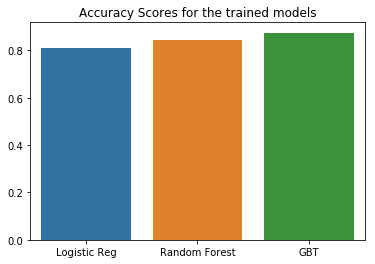

In [110]:
sns.barplot(y=accuracy_scores, x = ['Logistic Reg', 'Random Forest', 'GBT'])

plt.gca().set_title("Accuracy Scores for the trained models");

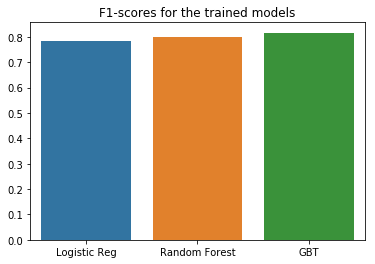

In [111]:
sns.barplot(y=f1_scores, x = ['Logistic Reg', 'Random Forest', 'GBT'])

plt.gca().set_title("F1-scores for the trained models");

In [112]:
gbt_feature_scores = [model_gbt.bestModel.stages[2].featureImportances[i] for i in range(0,33)]

In [176]:
#depreciated
#rfc_feature_scores = [model_rfc.bestModel.stages[2].featureImportances[i] for i in range(0,33)]

In [187]:
feature_importance = pd.DataFrame({'feature': input_columns, 'score': gbt_feature_scores}).sort_values(by="score", ascending=False)

In [188]:
feature_importance[0:10]

,feature,score
0,numberOfSessionItems,0.171777
18,machine_Windows 8,0.106555
4,browser_Chrome 35,0.098039
30,machine_Snow Leopard,0.097922
27,machine_Lion,0.081069
13,browser_IE 11,0.069006
22,machine_Windows 8_1,0.049519
12,browser_Chrome 36,0.045615
31,gender_F,0.040824
16,browser_Safari 7,0.040715


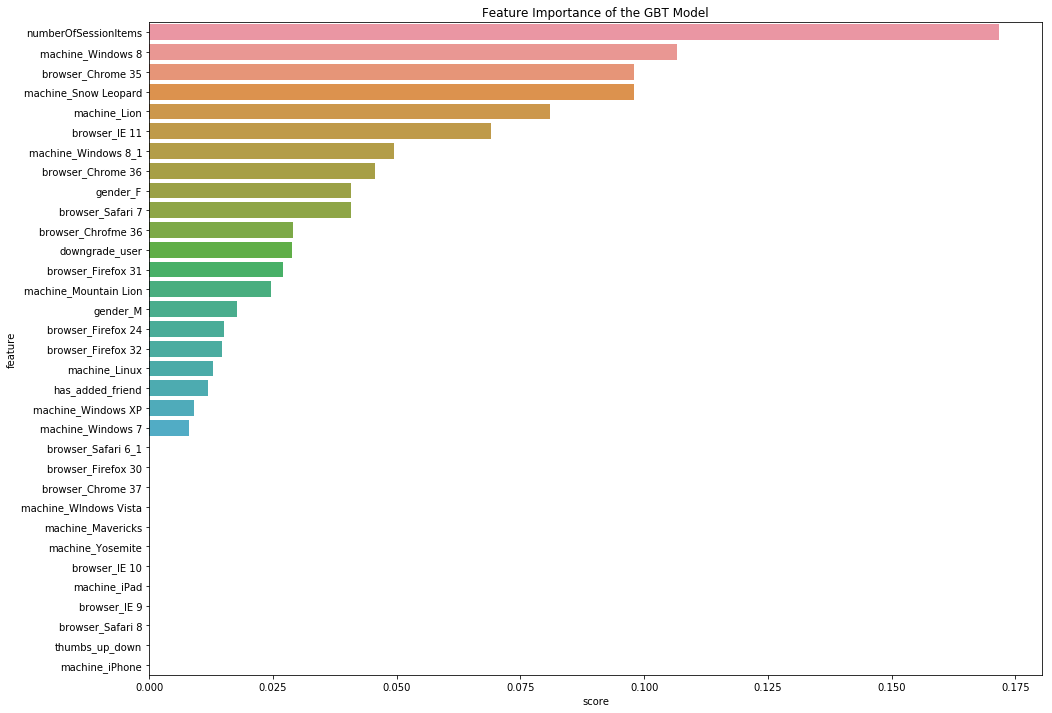

In [201]:
sns.barplot(data=feature_importance, y='feature', x='score')
f = plt.gcf()
f.set_size_inches(16,12)
plt.gca().set_title("Feature Importance of the GBT Model");

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.